## Setup

In [ ]:
import numpy as np
import pandas as pd

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

## Setup input pipeline


Initially this returns a dataset of (text, label pairs):

In [ ]:
df = pd.read_csv('https://www.dropbox.com/scl/fi/cr9ceee4wygmm1kn724sa/company_data_sentence_adjusted_by_keywords.csv?rlkey=fvt56wbmatwk5lpvvajxntbez&dl=1')
df = df.groupby('text').max().reset_index()

print('10 random samples:')
display(df.sample(10))

print('labels:')
print(df['label'].value_counts())

10 random samples:


,text,label
6168,We recognized additional discrete tax expense ...,0
3182,It would be rare for the Company to identify a...,0
1135,"As a result of, among other things, this conti...",0
3839,"Over the past 12 months, our liquid asset port...",1
4170,Significant items contributing to the changes ...,0
478,We use non-GAAP net income attributable to Na...,1
2677,"In July 2020, the U.K. enacted a reinstatement...",1
4628,The SPE may also enter into derivative contrac...,1
2754,"In addition, due to the global nature of our b...",0
3318,Many of these risks are interrelated and could...,0


labels:
0    3401
1    3161
Name: label, dtype: int64


Next shuffle the data for training and create batches of these `(text, label)` pairs:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
!mkdir knowledge_data
!mkdir knowledge_data/neg
!mkdir knowledge_data/pos

In [ ]:
for i in df[df['label']==0].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/neg/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()
for i in df[df['label']==1].index:
  txt = df.iloc[i]['text']
  text_file = open(f"knowledge_data/pos/{i}.txt", "wt")
  text_file.write(txt)
  text_file.close()

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_dataset = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_dataset = tf.keras.utils.text_dataset_from_directory(
    'knowledge_data',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

Found 6562 files belonging to 2 classes.
Using 5250 files for training.
Found 6562 files belonging to 2 classes.
Using 1312 files for validation.


In [ ]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'As a result of applying matched funding, interest revenue for each segment resulting from loans and other assets is generally not impacted by changes in interest rates'
 b'Net interest income decreased, primarily driven by a lower interest expense credit relating to internal transfer pricing, which results in a net benefit for GMNS due to its merchant payables'
 b'Of these assumptions, our discount rate and claim resolution rate assumptions have historically had the most significant effects on our level of reserves because many of our product lines provide benefit payments over an extended period of time. ']

labels:  [1 0 0]


In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'of', 'to', 'and', 'in', 'a', 'or', 'our',
       'as', 'due', 'for', 'are', 'that', 'on', 'result', 'we', 'may',
       'is'], dtype='<U15')

In [ ]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[ 10,   7,  16,   3,   1,   1, 355,  33, 109,  12, 200, 276, 304,
         20,  79,   5,  25,  54,  19, 150,  21, 637,  22,  34,   6,  33,
         56,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 55,  33,  38, 163,  53, 340,  22,   7,  68,  33, 117,  46, 699,
          4, 412, 536, 395,  29,  73,   6,   7,  55, 236,  12,   1,  11,
          4,  47,   1,   1,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  3,  28, 185,   9, 546,  58,   5, 352, 581,  58, 185,  32,   1,
        494,   2, 279,  70, 488,  15,   9, 133,   3, 195,  31, 213,   3,
          9, 388, 608, 220, 236, 216, 169,  30,   1, 101,   3, 119,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  

In [ ]:
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'As a result of applying matched funding, interest revenue for each segment resulting from loans and other assets is generally not impacted by changes in interest rates'
Round-trip:  as a result of [UNK] [UNK] funding interest revenue for each segment resulting from loans and other assets is generally not impacted by changes in interest rates                                     

Original:  b'Net interest income decreased, primarily driven by a lower interest expense credit relating to internal transfer pricing, which results in a net benefit for GMNS due to its merchant payables'
Round-trip:  net interest income decreased primarily driven by a lower interest expense credit relating to internal transfer pricing which results in a net benefit for [UNK] due to its [UNK] [UNK]                                  

Original:  b'Of these assumptions, our discount rate and claim resolution rate assumptions have historically had the most significant effects on our level of reserves b

## Create the model

![A drawing of the information flow in the model](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/bidirectional.png?raw=1)

The code to implement this is below:

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)

accuracy = tf.metrics.BinaryAccuracy()
recall = tf.metrics.Recall()
precision = tf.metrics.Precision()
metrics = [accuracy, recall, precision]

In [ ]:
model.compile(loss=loss,
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

## Train the model

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 32s 135ms/step - loss: 0.6905 - binary_accuracy: 0.5206 - recall: 0.0000e+00 - precision: 0.0000e+00 - val_loss: 0.6853 - val_binary_accuracy: 0.5125 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 3s 18ms/step - loss: 0.6334 - binary_accuracy: 0.5960 - recall: 0.2022 - precision: 0.8183 - val_loss: 0.5815 - val_binary_accuracy: 0.6802 - val_recall: 0.4444 - val_precision: 0.8346
Epoch 3/10
165/165 [==============================] - 4s 25ms/step - loss: 0.5452 - binary_accuracy: 0.7219 - recall: 0.5439 - precision: 0.8144 - val_loss: 0.5343 - val_binary_accuracy: 0.7292 - val_recall: 0.5408 - val_precision: 0.8456
Epoch 4/10
165/165 [==============================] - 3s 18ms/step - loss: 0.4780 - binary_accuracy: 0.7808 - recall: 0.6631 - precision: 0.8463 - val_loss: 0.4870 - val_binary_accuracy: 0.7656 - val_recall: 0.6400 - val_precision: 0.8492
Epoch 5/10
165/165 [======

In [ ]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 0s 8ms/step - loss: 0.4489 - binary_accuracy: 0.8163 - recall: 0.7547 - precision: 0.8541
Loss: 0.44890859723091125
Accuracy: 0.8163110017776489
Recall: 0.7546584010124207
Precision: 0.8541300296783447
F1: 0.8013190425256717


In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'binary_accuracy', 'recall', 'precision', 'val_loss', 'val_binary_accuracy', 'val_recall', 'val_precision'])


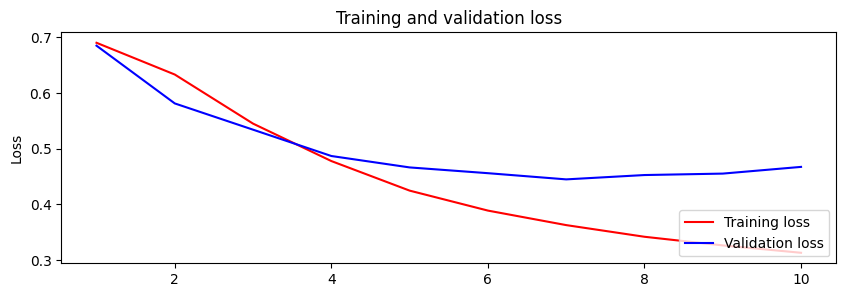

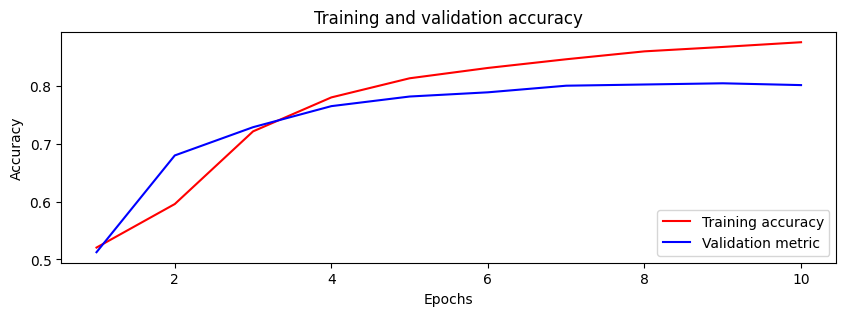

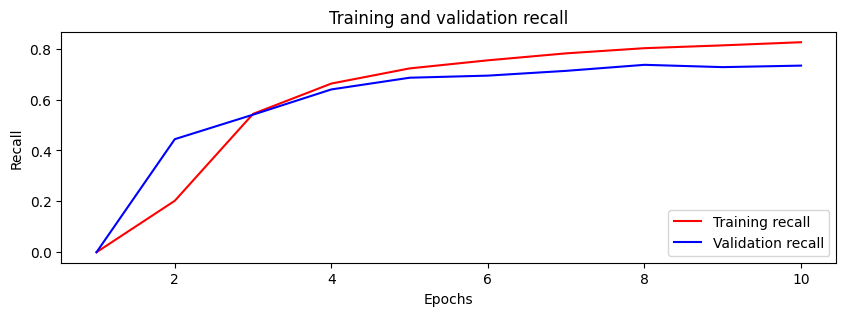

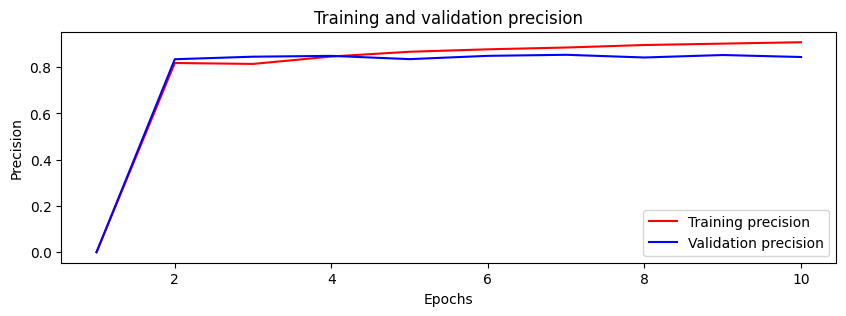

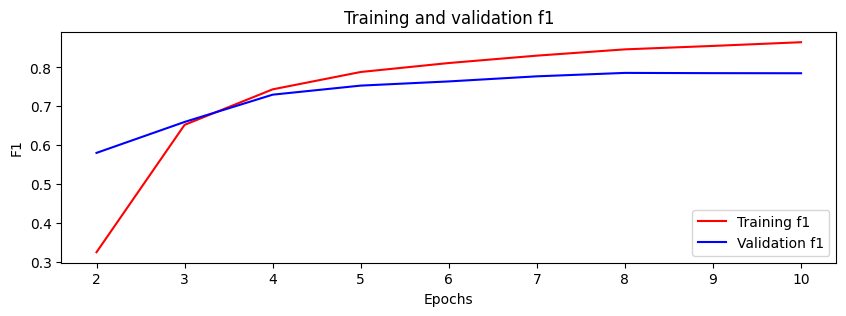

In [ ]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()

Run a prediction on a new sentence:

If the prediction is >= 0.0, it is positive else it is negative.

In [ ]:
sample_text = ('Bank of America hit with $250M in fines and refunds for double-dipping fees and fake accounts.')
predictions = model.predict(np.array([sample_text]))
predictions

1/1 [==============================] - 2s 2s/step


array([[-1.691513]], dtype=float32)

## Stack two or more LSTM layers

Keras recurrent layers have two available modes that are controlled by the `return_sequences` constructor argument:

* If `False` it returns only the last output for each input sequence (a 2D tensor of shape (batch_size, output_features)). This is the default, used in the previous model.

* If `True` the full sequences of successive outputs for each timestep is returned (a 3D tensor of shape `(batch_size, timesteps, output_features)`).

Here is what the flow of information looks like with `return_sequences=True`:

![layered_bidirectional](https://github.com/tensorflow/text/blob/master/docs/tutorials/images/layered_bidirectional.png?raw=1)

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=metrics)

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
165/165 [==============================] - 38s 132ms/step - loss: 0.6911 - binary_accuracy: 0.5797 - recall: 0.1537 - precision: 0.8541 - val_loss: 0.6831 - val_binary_accuracy: 0.5104 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/10
165/165 [==============================] - 6s 38ms/step - loss: 0.6063 - binary_accuracy: 0.6480 - recall: 0.3496 - precision: 0.8066 - val_loss: 0.5440 - val_binary_accuracy: 0.7417 - val_recall: 0.6383 - val_precision: 0.7937
Epoch 3/10
165/165 [==============================] - 5s 31ms/step - loss: 0.4962 - binary_accuracy: 0.7716 - recall: 0.6516 - precision: 0.8359 - val_loss: 0.4894 - val_binary_accuracy: 0.7740 - val_recall: 0.6957 - val_precision: 0.8155
Epoch 4/10
165/165 [==============================] - 6s 39ms/step - loss: 0.4310 - binary_accuracy: 0.8204 - recall: 0.7386 - precision: 0.8671 - val_loss: 0.4734 - val_binary_accuracy: 0.7896 - val_recall: 0.7255 - val_precision: 0.8237
Epoch 5/10
165/165 [==============

In [ ]:
loss, accuracy, recall, precision = model.evaluate(test_dataset)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')
print(f'Recall: {recall}')
print(f'Precision: {precision}')
print(f'F1: {2 * recall * precision / (recall + precision)}')

41/41 [==============================] - 0s 11ms/step - loss: 0.4871 - binary_accuracy: 0.8072 - recall: 0.7267 - precision: 0.8587
Loss: 0.4870522618293762
Accuracy: 0.8071646094322205
Recall: 0.7267080545425415
Precision: 0.8587155938148499
F1: 0.7872161352368836


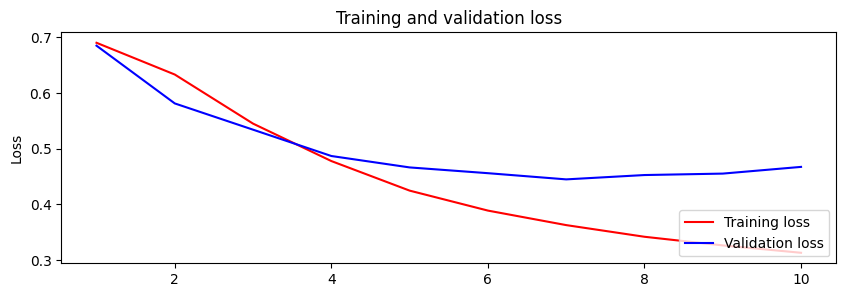

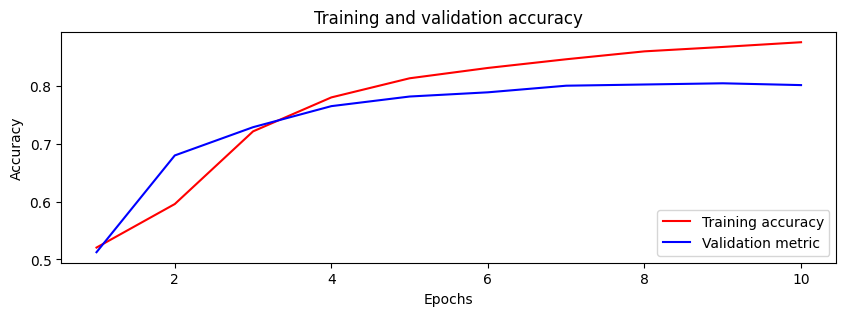

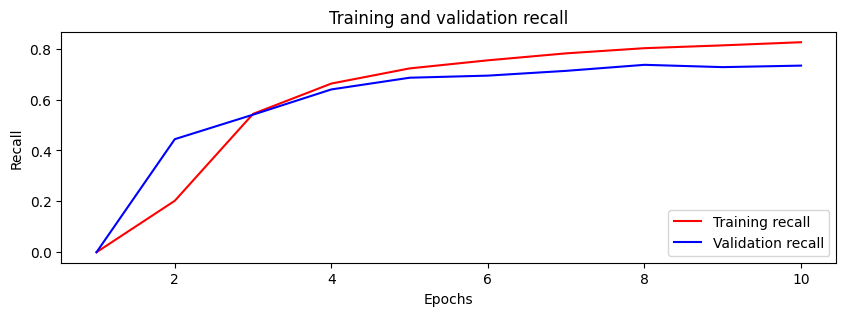

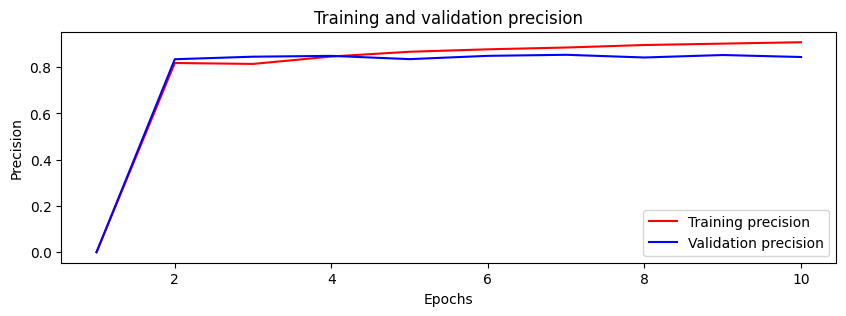

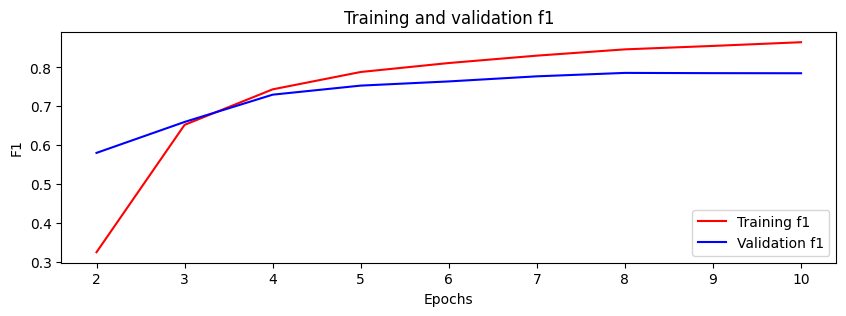

In [ ]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

accuracy = history_dict['binary_accuracy']
val_accuracy = history_dict['val_binary_accuracy']

recall = history_dict['recall']
val_recall = history_dict['val_recall']

precision = history_dict['precision']
val_precision = history_dict['val_precision']

f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(recall, precision) ]
val_f1 = [2 * i * j / (i + j) if (i + j) > 0 else None for i,j in zip(val_recall, val_precision)]

epochs = range(1, len(loss) + 1)
fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation metric')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, recall, 'r', label='Training recall')
plt.plot(epochs, val_recall, 'b', label='Validation recall')
plt.title('Training and validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, precision, 'r', label='Training precision')
plt.plot(epochs, val_precision, 'b', label='Validation precision')
plt.title('Training and validation precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend(loc='lower right')
plt.show()
plt.close()

fig = plt.figure(figsize=(10, 3))
fig.tight_layout()
plt.plot(epochs, f1, 'r', label='Training f1')
plt.plot(epochs, val_f1, 'b', label='Validation f1')
plt.title('Training and validation f1')
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend(loc='lower right')
plt.show()
plt.close()